In [1]:
# IMPORTS

import os
import sys
import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# VARIABLES

# Parameters
SIZE_X = 512    # Image height
SIZE_Y = 256    # Image width
n_classes = 14  # Number of classes for segmentation

# Paths
TRAIN_IMAGES_PATH = '/kaggle/input/oct-data/data_new/data/train/images'
TRAIN_MASKS_PATH = '/kaggle/input/oct-data/data_new/data/train/masks'

TEST_IMAGES_PATH = '/kaggle/input/oct-data/data_new/data/test/images'
TEST_MASKS_PATH = '/kaggle/input/oct-data/data_new/data/test/masks'

# Training parameters
num_epochs = 250
batch_size = 16 # Higher is better but requires more memory

# Set print options to display full arrays
np.set_printoptions(threshold=sys.maxsize)

# Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TensorBoard logger (TensorBoard does not seem to work on Kaggle currently)
logger = TensorBoardLogger('tb_logs', name='1')

In [3]:
# IMAGE LOADING AND PROCESSING

# Get image and mask file paths
train_images_ids = next(os.walk(TRAIN_IMAGES_PATH))[2]
train_masks_ids = next(os.walk(TRAIN_MASKS_PATH))[2]
test_images_ids = next(os.walk(TEST_IMAGES_PATH))[2]
test_masks_ids = next(os.walk(TEST_MASKS_PATH))[2]

#  Get and resize images
def get_resize_image(path):
    images = []
    for img_path in glob.glob(os.path.join(path, "*.png")): # Change the extension if needed
        img = cv2.imread(img_path, 0)                       # Read the image in grayscale mode    
        img = cv2.resize(img, (SIZE_Y, SIZE_X))             # Resize the image
        images.append(img)                                  # Append the image to the list
    return images                                           # Convert the list to a NumPy array

# Get and resize masks
def get_resize_masks(path):
    masks = []
    for mask_path in glob.glob(os.path.join(path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Prevent interpolation for the masks (nearest neighbor)
        masks.append(mask)
    return masks

train_images = np.array(get_resize_image(TRAIN_IMAGES_PATH)) # Convert the list to a NumPy array
train_masks = np.array(get_resize_masks(TRAIN_MASKS_PATH))

test_images = get_resize_image(TEST_IMAGES_PATH) # No need to convert to NumPy array, only for testing
test_masks = np.array(get_resize_masks(TEST_MASKS_PATH))

# Encode labels between 0 and n_classes, because PyTorch expects labels to be in this format for segmentation tasks 
def encode(labels):
    label_encoder = LabelEncoder()                                             # Initialize the label encoder
    n, h, w = labels.shape                                                     # Get the shape of the masks (n: batch size, h: height, w: width)
    labels_reshaped = labels.reshape(-1, 1)                                    # Reshape the masks to 2 dimensions
    labels_reshaped_encoded = label_encoder.fit_transform(labels_reshaped)     # Fit and transform the labels to fit between 0 and n_classes
    labels_encoded_original_shape = labels_reshaped_encoded.reshape(n, h, w)   # Reshape the encoded labels back to the original shape
    return labels_encoded_original_shape

train_masks_encoded = encode(train_masks)
test_masks_encoded = encode(test_masks)

# Expand dimensions to add a channel dimension for images and masks and normalize the images between 0 and 1
train_images = np.expand_dims(train_images, axis=3)
train_images = train_images / 255.0  # Normalization

test_images = np.expand_dims(test_images, axis=3)
test_images = test_images / 255.0  # Normalization

train_masks_input = np.expand_dims(train_masks_encoded, axis=3)
test_masks_input = np.expand_dims(test_masks_encoded, axis=3)

# Split the data into training and testing sets (80% training, 20% testing)
images_train, images_test, masks_train, masks_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)

# Convert labels to one-hot encoded format to match the output of the model (n_classes)
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.reshape(-1)].reshape((*y.shape[:-1], num_classes)) # eye creates an identity matrix of shape (num_classes, num_classes) and then reshapes it to the shape 
                                                                                    # of y with num_classes columns to get one-hot encoded labels
                                                                                    # *y.shape[:-1] is (256, 256) and y.reshape(-1) reshapes it to a 1D array
                                                                                    
train_masks_one_hot = one_hot_encode(masks_train, num_classes=n_classes)
masks_train_one_hot = train_masks_one_hot.reshape((masks_train.shape[0], masks_train.shape[1], masks_train.shape[2], n_classes)) # Reshape the one-hot encoded labels to the original shape

test_masks_one_hot = one_hot_encode(masks_test, num_classes=n_classes)
masks_test_one_hot = test_masks_one_hot.reshape((masks_test.shape[0], masks_test.shape[1], masks_test.shape[2], n_classes)) # Reshape the one-hot encoded labels to the original shape

# Convert the data to PyTorch tensors, permute the dimensions to match the format (N, C, H, W), and move them to the device
images_train = torch.tensor(images_train, dtype=torch.float32).permute(0, 3, 1, 2).to(device) 
masks_train_one_hot = torch.tensor(masks_train_one_hot, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
images_test = torch.tensor(images_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
masks_test_one_hot = torch.tensor(masks_test_one_hot, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
# UNET MODEL

class UNet(pl.LightningModule):
    def __init__(self, n_classes, img_channels):
        super(UNet, self).__init__()

        # Contraction path (encoder)
        # It reduces its spatial dimensions of the input image while increasing the number of channels.
        # This is done by applying a series of convolutions and pooling layers.
        # The output of each convolutional layer is passed through a ReLU activation function, which introduces non-linearity.
        # The output of each pooling layer is passed to the next layer and the output of the last layer is the input to the expansive path.
        
        self.conv1 = nn.Conv2d(img_channels, 16, kernel_size=3, padding=1) # The first convolutional layer takes the input image and applies 16 filters of size 3x3.
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)         # The second convolutional layer takes the output of the first layer and applies the same amount of filters.
        self.dropout1 = nn.Dropout(0.1)                                    # The dropout layer is used to prevent overfitting by randomly setting a fraction of the input units to zero.
        self.pool1 = nn.MaxPool2d(2, 2)                                    # The pooling layer reduces the spatial dimensions of the input by taking the maximum value in each 2x2 region.

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)           # The third convolutional layer takes the output of the pooling layer and applies 32 filters of size 3x3 and so on.
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(0.2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dropout4 = nn.Dropout(0.2)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dropout5 = nn.Dropout(0.3)

        # Expansive path (decoder)
        # It takes the output of the last convolutional layer in the contraction path and increases the spatial dimensions while reducing the number of channels.
        # This is done by applying a series of transposed convolutions and concatenating the output of each transposed convolution with the output of the corresponding convolution in the contraction path.
        # The output of each transposed convolution is passed through a ReLU activation function, which introduces non-linearity.
        # The output of the last transposed convolution is the final output of the network.

        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # The first transposed convolutional layer takes the output of the last convolutional layer in the contraction path and applies 128 filters of size 2x2.
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)       # The second convolutional layer takes the output of the transposed convolutional layer and applies 128 filters of size 3x3.
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)     # The third convolutional layer takes the output of the second convolutional layer and again applies 128 filters of size 3x3.
        self.dropout6 = nn.Dropout(0.2)                                  # The dropout layer is used to prevent overfitting by randomly setting a fraction of the input units to zero.

        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout7 = nn.Dropout(0.2)

        self.up8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv8_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.dropout8 = nn.Dropout(0.1)

        self.up9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv9_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.dropout9 = nn.Dropout(0.1)

        self.conv10 = nn.Conv2d(16, n_classes, kernel_size=1)

    # Computations performed at each forward pass of the network.
    def forward(self, x):
        # Contraction path
        c1 = F.relu(self.conv1(x))      # The input image is passed through the first convolutional layer and the output is passed through a ReLU activation function.
        c1 = F.relu(self.conv1_2(c1))   # The output of the first convolutional layer is passed through the second convolutional layer and the output is passed through a ReLU activation function.
        c1 = self.dropout1(c1)          # The output of the second convolutional layer is passed through a dropout layer.
        p1 = self.pool1(c1)             # The output of the dropout layer is passed through a pooling layer.

        c2 = F.relu(self.conv2(p1))
        c2 = F.relu(self.conv2_2(c2))
        c2 = self.dropout2(c2)
        p2 = self.pool2(c2)

        c3 = F.relu(self.conv3(p2))
        c3 = F.relu(self.conv3_2(c3))
        c3 = self.dropout3(c3)
        p3 = self.pool3(c3)

        c4 = F.relu(self.conv4(p3))
        c4 = F.relu(self.conv4_2(c4))
        c4 = self.dropout4(c4)
        p4 = self.pool4(c4)

        c5 = F.relu(self.conv5(p4))
        c5 = F.relu(self.conv5_2(c5))
        c5 = self.dropout5(c5)

        # Expansive path
        u6 = self.up6(c5)               # The output of the last convolutional layer in the contraction path is passed through the first transposed convolutional layer.
        u6 = torch.cat([u6, c4], dim=1) # The output of the transposed convolutional layer is concatenated with the output of the corresponding convolution in the contraction path.
        c6 = F.relu(self.conv6(u6))     # The concatenated output is passed through the second convolutional layer and the output is passed through a ReLU activation function.
        c6 = F.relu(self.conv6_2(c6))   # The output of the second convolutional layer is passed through the third convolutional layer and the output is again passed through a ReLU activation function.
        c6 = self.dropout6(c6)          # The output of the third convolutional layer is passed through a dropout layer.

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = F.relu(self.conv7(u7))
        c7 = F.relu(self.conv7_2(c7))
        c7 = self.dropout7(c7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = F.relu(self.conv8(u8))
        c8 = F.relu(self.conv8_2(c8))
        c8 = self.dropout8(c8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = F.relu(self.conv9(u9))
        c9 = F.relu(self.conv9_2(c9))
        c9 = self.dropout9(c9)

        outputs = self.conv10(c9)      # The output of the last convolutional layer is passed through a final convolutional layer to produce the final output of the network.

        return outputs

    # The training step is used to compute the training loss and update the weights of the network.
    def training_step(self, batch, batch_idx):
        x, y = batch                     # The input image and the target mask are unpacked from the batch.
        y_hat = self(x)                  # The input image is passed through the network to produce the output mask.
        y = y.squeeze(-1)                # The target mask is reshaped to match the output mask.
        loss = F.cross_entropy(y_hat, y) # The cross-entropy loss is computed between the output mask and the target mask.
        self.log("train_loss", loss)     # The loss is logged for visualization and returned.
        return loss
    
    # The validation step is used to compute the validation loss.
    def validation_step(self, batch, batch_idx):
        x,y = batch                           # The input image and the target mask are unpacked from the batch.
        y_hat = self(x)                       # The input image is passed through the network to produce the output mask.
        y = y.squeeze(-1)                     # The target mask is reshaped to match the output mask.
        val_loss = F.cross_entropy(y_hat, y)  # The cross-entropy loss is computed between the output mask and the target mask.
        self.log("val_loss", val_loss)        # The loss is logged for visualization and returned
        return val_loss                         
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [5]:
# TRAINING

# Initialize the model and move it to the device
model = UNet(n_classes=n_classes, img_channels=1).to(device) 

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-class segmentation

train_loader = DataLoader(list(zip(images_train, masks_train_one_hot)), batch_size=batch_size, shuffle=True) # DataLoader for training, shuffle the data for better training and generalization
test_loader = DataLoader(list(zip(images_test, masks_test_one_hot)), batch_size=batch_size, shuffle=False)   # DataLoader for testing

# train_losses, val_losses = [], [] # Lists to store training and validation losses

trainer = pl.Trainer(max_epochs=num_epochs, logger=logger) # PyTorch Lightning Trainer

trainer.fit(model, train_loader, test_loader) # Fit the model
    
# Save the model
torch.save(model.state_dict(), 'model.pth')
torch.save(model.state_dict(), '../testing_app/model.pth') # Save the model to the testing app directory

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [6]:
# MEAN IoU

# Put the model in evaluation mode and calculate the mean IoU (Jaccard Index) and Accuracy on the test set
model.eval().to(device)
jaccard_idx = MulticlassJaccardIndex(num_classes=n_classes).to(device)
accuracy = MulticlassAccuracy(num_classes=n_classes).to(device)

pred_masks = []
true_masks = []

# Get predictions and true labels for the test set and calculate the mean IoU
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)                     # Get the predictions
        preds = torch.argmax(outputs, dim=1)        # Get the predicted class by finding the index with the maximum value in the class dimension
        pred_masks.append(preds)                        # Append the predictions to the list
        true_masks.append(torch.argmax(labels, dim=1))  # Get the true class from the one-hot encoded labels

# Concatenate the lists into tensors
pred_masks = torch.cat(pred_masks, dim=0)
true_masks = torch.cat(true_masks, dim=0)

# Calculate and print the IoU (Jaccard Index) & Accuracy
iou = jaccard_idx(pred_masks, true_masks)
acc = accuracy(pred_masks, true_masks)
print("Mean IoU =", iou.item())
print("Accuracy =", acc.item())

Mean IoU = 0.6036953330039978
Accuracy = 0.7208034992218018


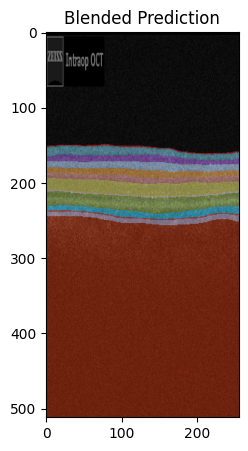

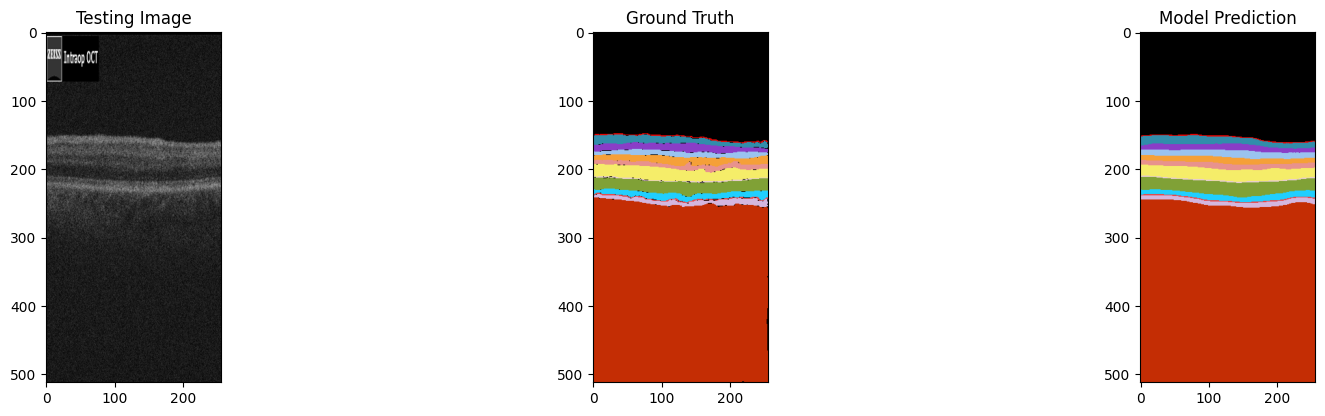

In [7]:
# TESTING

# TODO: Maybe add a loop to get multiple test images
test_img = test_images[0]

# Save a copy of the test image for plotting and convert it to a NumPy array with the correct shape
test_img_cpy = test_img.clone().detach().cpu().numpy()
test_img_cpy = np.squeeze(test_img_cpy, axis=0)         # Remove the batch dimension
test_img_cpy = np.expand_dims(test_img_cpy, axis=2)     # Add the channel dimension

# Get the first test mask (ground truth)
ground_truth = test_masks[0]

# Normalize the test image to be between 0 and 1 and add a channel dimension
test_img_norm = test_img[:, :, 0][:, :, None] 

# Ensure the image is on the correct device and shape
test_img_input = test_img.clone().detach().unsqueeze(0).to(device)

# Get prediction from the model
prediction = model(test_img_input)

# Get the predicted mask by finding the index with the maximum value in the class dimension
# and convert it to a NumPy array
predicted_img = torch.argmax(prediction, dim=1).squeeze(0).cpu().numpy()

# Test image has to be moved to the CPU and converted to numpy for plotting
test_img = test_img.cpu().numpy()

# Color map for the masks with the RGB values used in DeepVision
color_map = np.array([
        [0, 0, 0],       # Background
        [229, 4, 2],     # ILM
        [49, 141, 171],  # RNFL
        [138, 61, 199],  # GCL
        [154, 195, 239], # IPL
        [245, 160, 56],  # INL
        [232, 146, 141], # OPL
        [245, 237, 105], # ONL
        [232, 206, 208], # ELM
        [128, 161, 54],  # PR
        [32, 207, 255],  # RPE
        [232, 71, 72],   # BM
        [212, 182, 222], # CC
        [196, 45, 4],    # CS
])

# Apply the color map to the predicted and ground truth masks
predicted_img_color = color_map[predicted_img]
ground_truth_color = color_map[ground_truth]

# Plot the predicted blended image
plt.figure(figsize=(10, 5))
alpha = 0.5
plt.subplot(111)
plt.title('Blended Prediction')
plt.imshow(test_img_cpy[:, :, 0], cmap='gray')
plt.imshow(predicted_img_color, cmap='jet', alpha=alpha)

# Save the blended plot to a file
plt.savefig('prediction.png')

plt.show()

# Plot the three seperate images
plt.figure(figsize=(20, 10))

# Test image
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_cpy[:, :, 0], cmap='gray')

# Ground truth mask
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth_color, cmap='jet')

# Predicted mask
plt.subplot(233)
plt.title('Model Prediction')
plt.imshow(predicted_img_color, cmap='jet')
plt.show()